Este archivo es solo para seperar mi parte temporalmente y debuggearlo mejor, cuando este bien lo meto en el principal.

# LIBRERIAS

In [120]:
# %%
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from skimage import io
import warnings
warnings.filterwarnings('ignore')


# CARGA DE DATOS

In [121]:
import os

# Función para obtener rutas ordenadas por nombre de archivo
def get_sorted_paths(folder, extension="tiff"):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(extension)]
    )

# Rutas de las imágenes y las máscaras
img_paths = get_sorted_paths("roads/sat", extension="tiff")
mask_paths = get_sorted_paths("roads/gt", extension="tif")

# Verifica que el orden coincida
for img, mask in zip(img_paths, mask_paths):
    print(f"Imagen: {os.path.basename(img)}, Máscara: {os.path.basename(mask)}")

# Verificar si se encontraron archivos
if len(img_paths) == 0 or len(mask_paths) == 0:
    print("No se encontraron imágenes o máscaras. Verifica las rutas.")
else:
    print(f"Imágenes encontradas: {len(img_paths)} | Máscaras encontradas: {len(mask_paths)}")


Imagen: 10078675_15.tiff, Máscara: 10078675_15.tif
Imagen: 10228675_15.tiff, Máscara: 10228675_15.tif
Imagen: 10228705_15.tiff, Máscara: 10228705_15.tif
Imagen: 10228720_15.tiff, Máscara: 10228720_15.tif
Imagen: 10228735_15.tiff, Máscara: 10228735_15.tif
Imagen: 10228750_15.tiff, Máscara: 10228750_15.tif
Imagen: 10378675_15.tiff, Máscara: 10378675_15.tif
Imagen: 10378690_15.tiff, Máscara: 10378690_15.tif
Imagen: 10378705_15.tiff, Máscara: 10378705_15.tif
Imagen: 10378720_15.tiff, Máscara: 10378720_15.tif
Imagen: 10378735_15.tiff, Máscara: 10378735_15.tif
Imagen: 10378750_15.tiff, Máscara: 10378750_15.tif
Imagen: 10378765_15.tiff, Máscara: 10378765_15.tif
Imagen: 10528675_15.tiff, Máscara: 10528675_15.tif
Imagen: 10528690_15.tiff, Máscara: 10528690_15.tif
Imagen: 10528705_15.tiff, Máscara: 10528705_15.tif
Imagen: 10528720_15.tiff, Máscara: 10528720_15.tif
Imagen: 10528735_15.tiff, Máscara: 10528735_15.tif
Imagen: 10528750_15.tiff, Máscara: 10528750_15.tif
Imagen: 10528765_15.tiff, Másca

## PROCESADO

In [122]:
def load_data(img_paths, mask_paths, img_size=(256, 256)):
    imgs = []
    masks = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar y redimensionar imagen
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)

        # Cargar y redimensionar máscara
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = (mask > 0).astype('float32')  # Binarizar la máscara
        masks.append(mask)

    return np.array(imgs), np.array(masks)

img_size = (256, 256)
X, y = load_data(img_paths, mask_paths, img_size=img_size)

# Verificar formas
print(f"Forma de imágenes: {X.shape}")
print(f"Forma de máscaras: {y.shape}")


Forma de imágenes: (20, 256, 256, 3)
Forma de máscaras: (20, 256, 256)


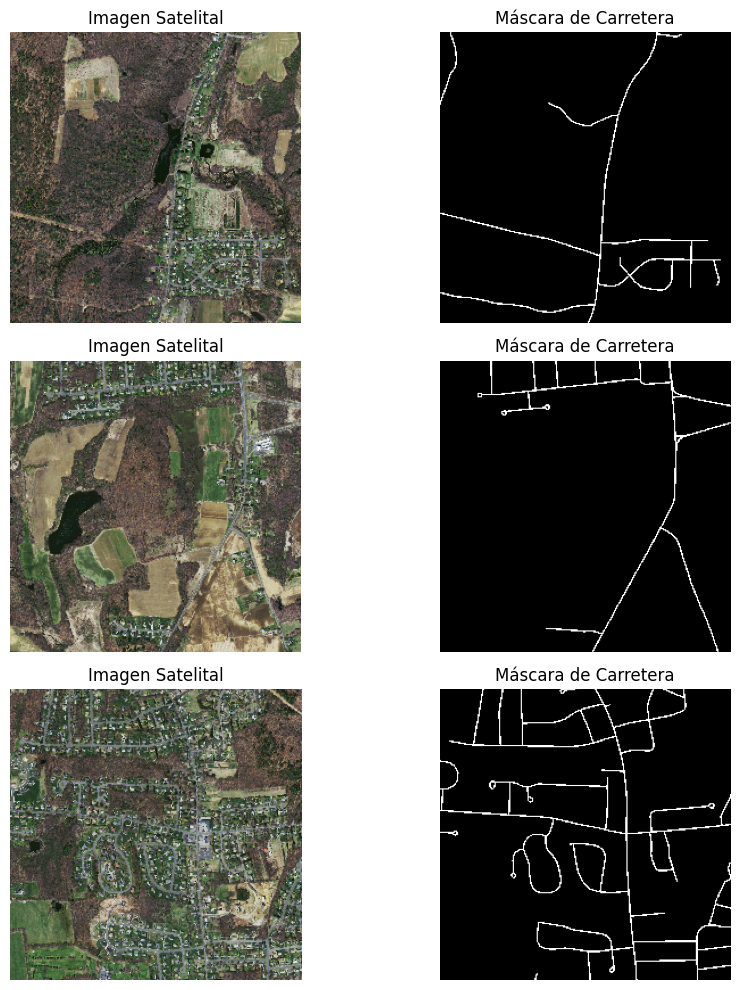

In [123]:
# Mostrar algunas imágenes y sus máscaras correspondientes
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))
for i in range(num_samples):
    axes[i, 0].imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Imagen Satelital')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(y[i], cmap='gray')
    axes[i, 1].set_title('Máscara de Carretera')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


# EXTRACCION DE CARACTERISTICAS

In [124]:
def extract_features(img):
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detector de bordes de Canny
    edges = cv2.Canny((gray * 255).astype(np.uint8), threshold1=100, threshold2=200)
    edges_flat = edges.flatten()
    
    # Aplanar la imagen en RGB
    r = img[:, :, 2].flatten()  # Canal R
    g = img[:, :, 1].flatten()  # Canal G
    b = img[:, :, 0].flatten()  # Canal B
    
    # Concatenar características
    features = np.column_stack((r, g, b, edges_flat))
    
    return features


In [125]:
# %%
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops

def apply_gabor_filter(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kernel = cv2.getGaborKernel(
            ksize=(21, 21),
            sigma=8.0,
            theta=theta,
            lambd=10.0,
            gamma=0.5,
            psi=0,
            ktype=cv2.CV_32F
        )
        kernels.append(kernel)
    features = []
    for kernel in kernels:
        fimg = cv2.filter2D(gray, cv2.CV_32F, kernel)
        features.append(fimg.flatten())
    # Apilar características a lo largo de las columnas
    features = np.column_stack(features)
    return features  # Forma: (65536, 4)


def extract_edge_features(img):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convertir a uint8
    gray_uint8 = (gray * 255).astype(np.uint8)
    
    # Sobel en la imagen original en float32
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2).flatten()
    
    # Laplacian en la imagen uint8
    laplacian = cv2.Laplacian(gray_uint8, cv2.CV_64F).flatten()
    
    return np.column_stack((sobel_combined, laplacian))


def calculate_ndvi(img):
    # Convertir a float para evitar errores de división
    img = img.astype(float) + 1e-6
    # Asumiendo que el canal NIR es el canal R (ajustar según tus datos)
    nir = img[:, :, 2]  # Canal R
    red = img[:, :, 0]  # Canal B
    ndvi = (nir - red) / (nir + red)
    return ndvi.flatten()

def extract_features(img):
    # Intensidad RGB
    r = img[:, :, 2].flatten()  # Canal R
    g = img[:, :, 1].flatten()  # Canal G
    b = img[:, :, 0].flatten()  # Canal B
    
    # Filtros de Gabor
    gabor_feats = apply_gabor_filter(img)
    
    # Bordes
    edge_feats = extract_edge_features(img)
    
    # NDVI
    ndvi = calculate_ndvi(img).flatten()
    
    # Concatenar todas las características
    features = np.column_stack((
        r, g, b,                # (65536, 3)
        edge_feats,             # (65536, 2)
        gabor_feats,            # (65536, 4)
        ndvi                    # (65536,)
    ))
    
    return features  # Forma final: (65536, 10)




In [126]:
# Asegurarse de que las dimensiones sean correctas
assert X.shape[0] == y.shape[0], "El número de imágenes y máscaras no coincide."

# Inicializar listas
features_list = []
labels_list = []

for img, mask in zip(X, y):
    # Extraer características
    features = extract_features(img)
    features_list.append(features)
    # Aplanar la máscara
    labels = mask.flatten()
    labels_list.append(labels)

# Convertir listas a arrays
X_features = np.vstack(features_list)
y_labels = np.hstack(labels_list)

print(f"Características extraídas: {X_features.shape}")
print(f"Etiquetas extraídas: {y_labels.shape}")


Características extraídas: (1310720, 10)
Etiquetas extraídas: (1310720,)


# DESBALANCEO DE CLASES

In [127]:
from collections import Counter

# Contar las muestras por clase
class_counts = Counter(y_labels)
print(f"Distribución de clases antes del oversampling: {class_counts}")


Distribución de clases antes del oversampling: Counter({np.float32(0.0): 1253444, np.float32(1.0): 57276})


In [128]:
# %%
from sklearn.utils import resample

# Separar datos por clase
X_class0 = X_features[y_labels == 0]
X_class1 = X_features[y_labels == 1]
y_class0 = y_labels[y_labels == 0]
y_class1 = y_labels[y_labels == 1]

# Realizar undersampling de la clase mayoritaria (clase 0)
X_class0_downsampled, y_class0_downsampled = resample(
    X_class0,
    y_class0,
    replace=False,  # Sin reemplazo
    n_samples=len(y_class1),  # Igualar al número de muestras de la clase minoritaria
    random_state=42
)

# Combinar datos
X_balanced = np.vstack((X_class0_downsampled, X_class1))
y_balanced = np.hstack((y_class0_downsampled, y_class1))

# Verificar el balance de clases
class_counts_balanced = Counter(y_balanced)
print(f"Distribución de clases después del undersampling: {class_counts_balanced}")


Distribución de clases después del undersampling: Counter({np.float32(0.0): 57276, np.float32(1.0): 57276})


# ENTRENAMIENTO

In [129]:
# %%
from sklearn.model_selection import train_test_split

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# %%
from xgboost import XGBClassifier

# Crear y entrenar el modelo
clf = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [130]:
# %%
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from xgboost import XGBClassifier

# Asegurarse de que los datos estén en formato numpy arrays
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

# Configurar k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inicializar listas para almacenar métricas
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

fold = 1
for train_index, test_index in skf.split(X_balanced, y_balanced):
    print(f"Fold {fold}/{n_splits}")
    
    # Dividir los datos en entrenamiento y prueba para este fold
    X_train_fold, X_test_fold = X_balanced[train_index], X_balanced[test_index]
    y_train_fold, y_test_fold = y_balanced[train_index], y_balanced[test_index]
    
    # Crear y entrenar el modelo
    clf = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                        random_state=42, n_jobs=-1)
    clf.fit(X_train_fold, y_train_fold)
    
    # Predecir en el conjunto de prueba
    y_pred = clf.predict(X_test_fold)
    y_pred_proba = clf.predict_proba(X_test_fold)[:, 1]
    
    # Calcular métricas
    precision = precision_score(y_test_fold, y_pred, zero_division=0)
    recall = recall_score(y_test_fold, y_pred, zero_division=0)
    f1 = f1_score(y_test_fold, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
    
    # Almacenar métricas
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    
    print(f"Precisión: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}\n")
    fold += 1

# Calcular métricas promedio
print("Resultados Promedio:")
print(f"Precisión Promedio: {np.mean(precisions):.4f}")
print(f"Recall Promedio: {np.mean(recalls):.4f}")
print(f"F1-Score Promedio: {np.mean(f1_scores):.4f}")
print(f"ROC-AUC Promedio: {np.mean(roc_aucs):.4f}")


Fold 1/5
Precisión: 0.8636, Recall: 0.8477, F1-Score: 0.8555, ROC-AUC: 0.9164

Fold 2/5
Precisión: 0.8670, Recall: 0.8456, F1-Score: 0.8562, ROC-AUC: 0.9170

Fold 3/5
Precisión: 0.8624, Recall: 0.8592, F1-Score: 0.8608, ROC-AUC: 0.9200

Fold 4/5
Precisión: 0.8554, Recall: 0.8553, F1-Score: 0.8554, ROC-AUC: 0.9140

Fold 5/5
Precisión: 0.8593, Recall: 0.8529, F1-Score: 0.8561, ROC-AUC: 0.9138

Resultados Promedio:
Precisión Promedio: 0.8615
Recall Promedio: 0.8521
F1-Score Promedio: 0.8568
ROC-AUC Promedio: 0.9162


# EVALUACION

In [131]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predecir en el conjunto de prueba
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calcular métricas
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Precisión: 0.8636
Recall: 0.8631
F1-Score: 0.8633
ROC-AUC: 0.9249


In [132]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)


Matriz de Confusión:
[[9894 1562]
 [1568 9887]]


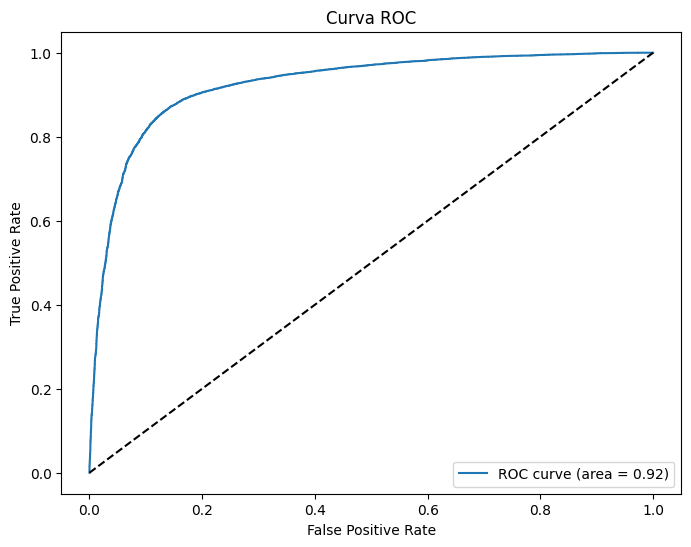

In [133]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# COMPROBAR NUEVAS IMAGENES

In [134]:
# Preprocesamiento de la imagen
def preprocess_image(img_path, img_size=(256, 256)):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, img_size)
    img_resized = img_resized.astype('float32') / 255.0
    return img_resized

# Postprocesamiento de la máscara
def postprocess_mask(mask, img_size):
    mask = mask.reshape(img_size)
    mask = (mask > 0.5).astype(np.uint8)
    return mask


Forma de la imagen: (256, 256, 3)


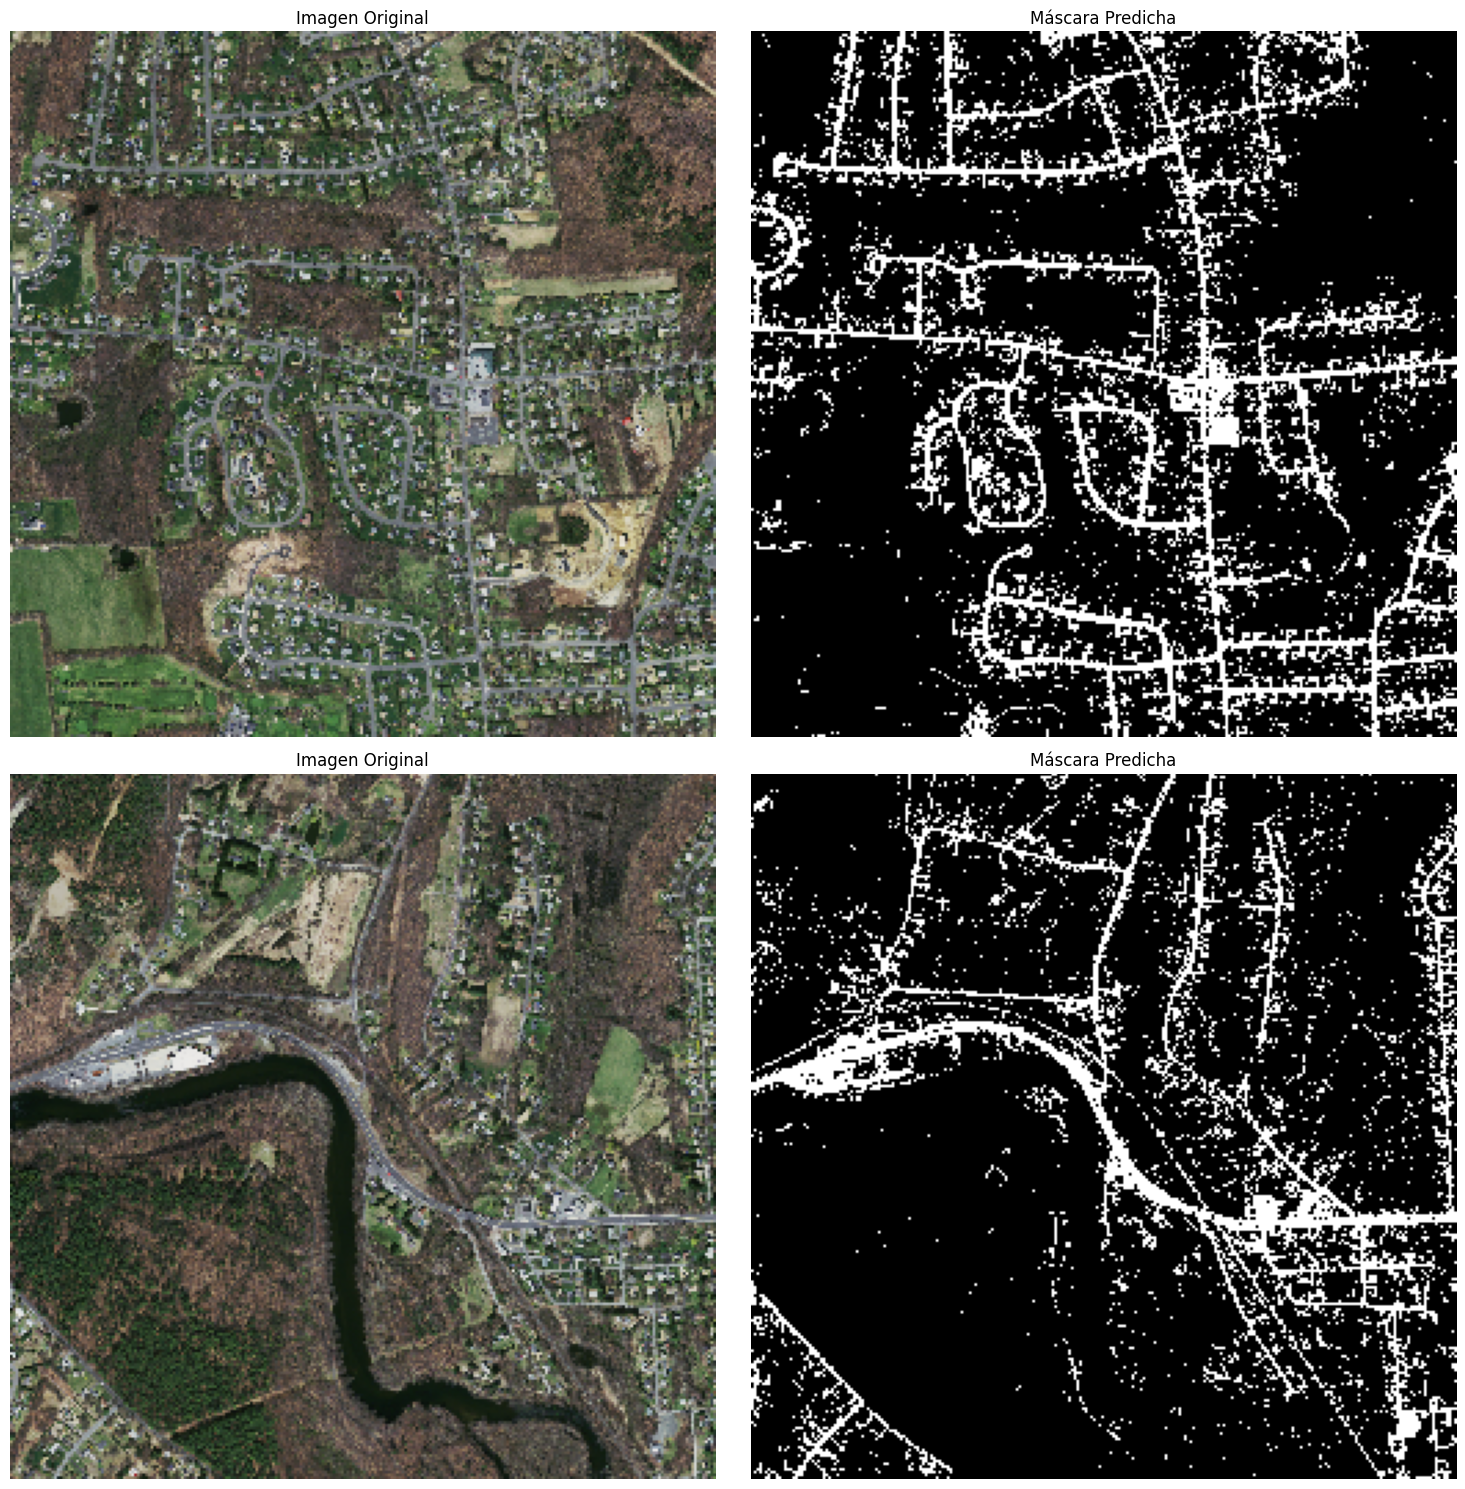

In [141]:
# Ruta a la nueva imagen
new_img_path = "roads/sat/10228705_15.tiff"
new_img_path2 = "roads/sat/10228735_15.tiff" 
# Preprocesar la imagen
new_image = preprocess_image(new_img_path, img_size=img_size)
new_image2 = preprocess_image(new_img_path2, img_size=img_size)

# Verificar forma
print(f"Forma de la imagen: {new_image.shape}")

# Extraer características
features_new_image = extract_features(new_image)
features_new_image2 = extract_features(new_image2)

# Predecir la máscara
mask_pred = clf.predict(features_new_image)
mask_pred2 = clf.predict(features_new_image2)

# Postprocesar la máscara
mask_pred_processed = postprocess_mask(mask_pred, img_size)
mask_pred_processed2 = postprocess_mask(mask_pred2, img_size)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(mask_pred_processed, cmap='gray')
plt.title('Máscara Predicha')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB))
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(mask_pred_processed2, cmap='gray')
plt.title('Máscara Predicha')
plt.axis('off')
plt.tight_layout()
plt.show()


# POSTPROCESADO